In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from keras_preprocessing.image import ImageDataGenerator

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import pathlib
import tensorflow as tf
%matplotlib inline

In [3]:
#import tensorflow as tf
#tf.test.gpu_device_name()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rescaled = ImageDataGenerator(1/255)
train_fed = tf.keras.utils.image_dataset_from_directory('/kaggle/input/intel-image-classification/seg_train/seg_train', image_size = (128,128), batch_size=32, label_mode = 'categorical', subset='training', validation_split = 0.2, seed=42)
test_fed = tf.keras.utils.image_dataset_from_directory('/kaggle/input/intel-image-classification/seg_test/seg_test', image_size = (128,128), batch_size=32, label_mode = 'categorical', subset='validation', validation_split = 0.2, seed=42)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


2022-11-26 18:00:26.621890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.622768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.633015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.633759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.634516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 3000 files belonging to 6 classes.
Using 600 files for validation.


2022-11-26 18:00:26.639310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 18:00:26.864820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.865678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:00:26.866455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #1st layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #2nd layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #3rd layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #4th layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')                                                       
])

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 122, 122, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 61, 61, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 59, 59, 32)        4640      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 57, 57, 32)       

In [64]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

In [66]:
erl_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mod_chk = ModelCheckpoint(filepath='/kaggle/working/my_model.hdf5', monitor='val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)

In [67]:
hist = model.fit(train_fed, shuffle=True, epochs=20, validation_data=test_fed,
                           callbacks=[erl_stop, mod_chk, lr_rate], verbose=1)

Epoch 1/20
351/351 [==============================] - 15s 41ms/step - loss: 1.4573 - accuracy: 0.3457 - val_loss: 1.1650 - val_accuracy: 0.4800
Epoch 2/20
351/351 [==============================] - 15s 41ms/step - loss: 1.1173 - accuracy: 0.5208 - val_loss: 1.0077 - val_accuracy: 0.5650
Epoch 3/20
351/351 [==============================] - 15s 41ms/step - loss: 0.9706 - accuracy: 0.6068 - val_loss: 0.9127 - val_accuracy: 0.6500
Epoch 4/20
351/351 [==============================] - 15s 43ms/step - loss: 0.8711 - accuracy: 0.6659 - val_loss: 0.8190 - val_accuracy: 0.7067
Epoch 5/20
351/351 [==============================] - 15s 41ms/step - loss: 0.7923 - accuracy: 0.6977 - val_loss: 0.8603 - val_accuracy: 0.6700
Epoch 6/20
351/351 [==============================] - 15s 41ms/step - loss: 0.7599 - accuracy: 0.7166 - val_loss: 0.8159 - val_accuracy: 0.7133
Epoch 7/20
351/351 [==============================] - 15s 41ms/step - loss: 0.7010 - accuracy: 0.7408 - val_loss: 0.7310 - val_accuracy:

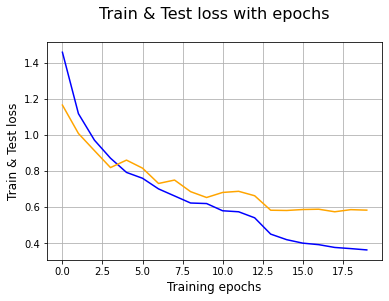

In [68]:
#Plotting results
plt.plot(hist.history['loss'], color='blue', label='train')
plt.plot(hist.history['val_loss'], color='orange', label='train')
plt.grid(True)
plt.title("Train & Test loss with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test loss", fontsize=12)
plt.show();

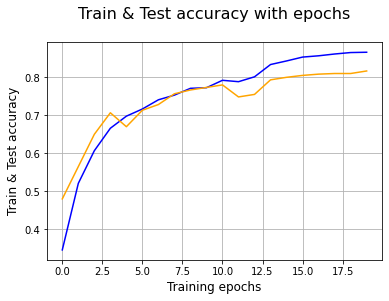

In [69]:
#Plotting results with accuracy
plt.plot(hist.history['accuracy'], color='blue', label='train')
plt.plot(hist.history['val_accuracy'], color='orange', label='train')
plt.grid(True)
plt.title("Train & Test accuracy with epochs\n", fontsize=16)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Train & Test accuracy", fontsize=12)
plt.show();

In [70]:
acc = model.evaluate(test_fed, steps=len(test_fed), verbose=1)
print('%.2f'%(acc[1]*100))

19/19 [==============================] - 1s 21ms/step - loss: 0.5834 - accuracy: 0.8167
81.67
